# Introduction 

This notebook looks at the amount of comments a pull request received. Both disccusion and code-level comments are analyzed.  

In [155]:
%load_ext autoreload
%autoreload 2

from pymongo import MongoClient

mongo_client = MongoClient()

database = mongo_client["graduation"]

pull_requests_collection = database["pull_requests"]

projects_collection = database["projects"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [156]:
import analysis_utilities

projects = list(projects_collection.find({'succeeded' : True, 'status_travis_date' : {"$exists" : True}}))

print("Found {} projects with a travis build status date".format(len(projects)))

Found 52 projects with a travis build status date


In [157]:
project_names = []

inline_review_before = []
inline_review_after = []

for project in projects[:10]:
    project_names.append(project["full_name"])
    
    prs = list(pull_requests_collection.find({'project_name': project["full_name"].split("/")[1],'project_owner': project["full_name"].split("/")[0]}))
    
    prs_before, prs_after = analysis_utilities.split_prs_on_build_date(project, prs, True, "status_travis_date")
    
    inline_review_before.append([len(pr["review_comments"]) for pr in prs_before])
    inline_review_after.append([len(pr["review_comments"]) for pr in prs_after])
    

 

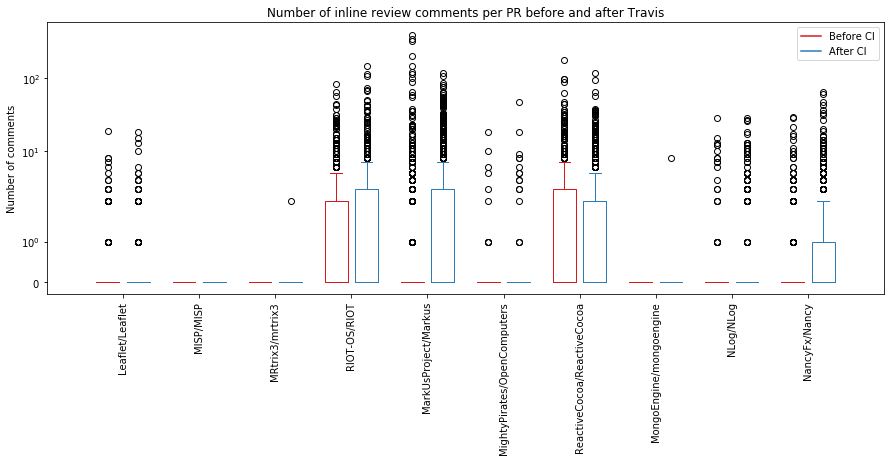

In [158]:
analysis_utilities.do_before_after_boxplot(inline_review_before, inline_review_after, project_names, 
                       'Number of inline review comments per PR before and after Travis',
                       'Number of comments',
                       yscale='symlog')

In [ ]:
for project in projects:    
    prs = list(pull_requests_collection.find({'project_name': project["full_name"].split("/")[1],'project_owner': project["full_name"].split("/")[0]}))
    
    usernames = []
            
    for pr in prs:
        
        usernames.append(pr["user"]["login"])
        
        usernames.extend(ngramizer.given_text_extract_usernames(pr["body"]))
        
        for comment in pr["raw_comments"]:
            usernames.append(comment["user"]["login"])
            usernames.extend(ngramizer.given_text_extract_usernames(comment["body"]))
            
    usernames = list(set(usernames))
            
    project["usernames"] = usernames
        
    
    for pr in prs:
        if not ngramizer.is_bot_comment(pr["user"]["login"]):
            
            counter = Counter()
            linkback = {}
            
            ngramizer.add_text_ngrams_to_counter(pr["body"], pr.get("html_url", ""), ngram_length, counter, linkback, project["usernames"])
        
        for comment in pr["raw_comments"]:
            if not ngramizer.is_bot_comment(comment["user"]["login"]):
                counter = Counter()
                linkback = {}
                
                ngramizer.add_text_ngrams_to_counter(comment["body"], comment.get("html_url", ""), ngram_length, counter, linkback, project["usernames"])
            

In [168]:
# This cell exports review data for analysis with R

filename = "generated/num_of_review_comments.csv"

import csv

with open(filename, mode='w') as num_of_review_comments_file:
    writer = csv.writer(num_of_review_comments_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow([
        'ReviewComments', 
        'ShareReviewComments',
        'GeneralComments',
        'GeneralCommentsDiscussingBuild',
        'Additions',
        'Deletions',
        'IsMerged',
        'Commits',
        'Assignees',
        'ChangedFiles',
        'PrOpenedDaysAfterProjectStart',
        'ProjectLanguage',
        'IsAfter',
        'ProjectName'       
        ])
    
    for project in projects:
        prs = list(pull_requests_collection.find({'project_name': project["full_name"].split("/")[1],'project_owner': project["full_name"].split("/")[0]}))

        usernames = []
            
        for pr in prs:

            usernames.append(pr["user"]["login"])

            usernames.extend(ngramizer.given_text_extract_usernames(pr["body"]))

            for comment in pr["raw_comments"]:
                usernames.append(comment["user"]["login"])
                usernames.extend(ngramizer.given_text_extract_usernames(comment["body"]))

        usernames = list(set(usernames))

        project["usernames"] = usernames

        build_terms = ["travi", "continuousintegr", "deploy", "build"]
        
        def does_item_discuss_build(discussion_item, counter):
            for item in counter:
                for term in build_terms:
                    if term in item:
                        discussion_item["discusses_build"] = True
                        return
                    
            discussion_item["discusses_build"] = False

        for pr in prs:
            if not ngramizer.is_bot_comment(pr["user"]["login"]):

                counter = Counter()
                linkback = {}

                ngramizer.add_text_ngrams_to_counter(pr["body"], pr.get("html_url", ""), ngram_length, counter, linkback, project["usernames"])

                does_item_discuss_build(pr, counter)
            else:
                pr["discusses_build"] = False
                
            for comment in pr["raw_comments"]:
                if not ngramizer.is_bot_comment(comment["user"]["login"]):
                    counter = Counter()
                    linkback = {}

                    ngramizer.add_text_ngrams_to_counter(comment["body"], comment.get("html_url", ""), ngram_length, counter, linkback, project["usernames"])
                    
                    does_item_discuss_build(comment, counter)
                else:
                    comment["discusses_build"] = False
        
        prs_before, prs_after = analysis_utilities.split_prs_on_build_date(project, prs, True, "status_travis_date")
        
        if len(prs_before) < 100 or len(prs_after) < 100:
            continue
            
        def write_row(pr, is_after):
            project_days_since_pr_start = (pr["created_at"] - project["created_at"]).days
            
            share = 0 if len(pr["raw_comments"]) + len(pr["review_comments"]) == 0 else len(pr["review_comments"]) / (len(pr["review_comments"]) + len(pr["raw_comments"])) * 100 
            
            writer.writerow([
                len(pr["review_comments"]),
                share,
                len(pr["raw_comments"]),
                len([cmmnt for cmmnt in pr["raw_comments"] if cmmnt["discusses_build"]]),
                pr["additions"],
                pr["deletions"],
                pr["merged"],
                len(pr["commits"]),
                len(pr["assignees"]),
                pr["changed_files"],
                project_days_since_pr_start,
                project["language"],
                is_after,
                project["full_name"]
            ])
            
        for pr in prs_before:
            write_row(pr, False)
            
        for pr in prs_after:
            write_row(pr, True)

In [160]:
shares_before = []
shares_after = []

for project in projects:
    project_names.append(project["full_name"])
    
    prs = list(pull_requests_collection.find({'project_name': project["full_name"].split("/")[1],'project_owner': project["full_name"].split("/")[0]}))
    
    prs_before, prs_after = analysis_utilities.split_prs_on_build_date(project, prs, True)
    
    if len(prs_before) < 200 or len(prs_after) < 200:
        continue
    
    total_review_comments_before = sum([len(pr["review_comments"])  for pr in prs_before])
    total_general_comments_before = sum([len(pr["raw_comments"])  for pr in prs_before])
    
    total_before = total_review_comments_before + total_general_comments_before    
        
    total_review_comments_after = sum([len(pr["review_comments"])  for pr in prs_after])
    total_general_comments_after = sum([len(pr["raw_comments"])  for pr in prs_after])
    
    total_after = total_review_comments_after + total_general_comments_after
    
    if total_before == 0 or total_after == 0:
        continue
    
    share_review_comments_before = total_review_comments_before / (total_review_comments_before + total_general_comments_before)
    share_review_comments_after = total_review_comments_after / (total_review_comments_after + total_general_comments_after)
    
    shares_before.append(share_review_comments_before)
    shares_after.append(share_review_comments_after)
    


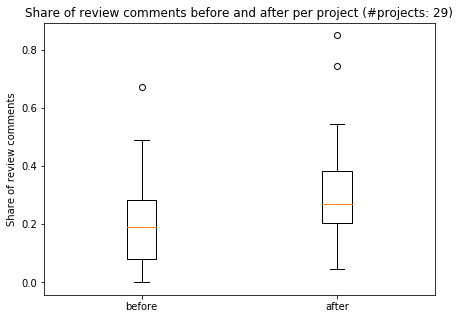

In [161]:
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np


plt.figure(figsize=(7,5))

plt.title("Share of review comments before and after per project (#projects: {})".format(len(shares_before)))
plt.ylabel("Share of review comments")

plt.boxplot([shares_before, shares_after])
plt.xticks(np.arange(2) + 1, ["before", "after"])

plt.show()

In [162]:
from scipy import stats

stats.ttest_rel(shares_before, shares_after)

Ttest_relResult(statistic=-4.721278802347606, pvalue=5.9415525931645924e-05)



# Time series

In [163]:
from datetime import datetime, timedelta
   
period = 30
periods = 24

metrics = [[] for x in range(periods + 1)]

for project in projects:
    project_names.append(project["full_name"])
    
    prs = list(pull_requests_collection.find({'project_name': project["full_name"].split("/")[1],'project_owner': project["full_name"].split("/")[0]}))
    
    #prs_before, prs_after = analysis_utilities.split_prs_on_build_date(project, prs, True)
    
    travis_date = project["status_travis_date"]
    
    start_date = travis_date - timedelta(days=period/2 + period*(periods/2))
    
    empty_period = False
    
    split_prs = []
    
    for i in range(periods + 1):
        end_date = start_date + timedelta(days=period)
        
        prs_in_period = []
        
        for pr in prs:
            if pr["created_at"] > start_date and pr["created_at"] < end_date:
                prs_in_period.append(pr)
                
        if len(prs_in_period) == 0:
            empty_period = True
            break
            
        split_prs.append(prs_in_period)
            
        start_date = end_date
        
    if empty_period:
        continue
    
    print("{} is valid".format(project["full_name"]))
    
    for i in range(len(split_prs)):
        prs_in_period = split_prs[i]
        
        total_review_comments = sum([len(pr["review_comments"]) for pr in prs_in_period])
        total_general_comments = sum([len(pr["raw_comments"]) for pr in prs_in_period])

        total = total_review_comments + total_general_comments   
        
        if total == 0:
            continue 
        
        share_review_comments = total_review_comments / total
        
        metrics[i].append(share_review_comments)
    

Leaflet/Leaflet is valid
MarkUsProject/Markus is valid
ReactiveCocoa/ReactiveCocoa is valid
NLog/NLog is valid
NancyFx/Nancy is valid
OP2/PyOP2 is valid
OPM/opm-core is valid
OPM/opm-parser is valid
RestKit/RestKit is valid
Smoothieware/Smoothieware is valid
AFNetworking/AFNetworking is valid
Theano/Theano is valid
OpenTreeMap/otm-core is valid
PCSX2/pcsx2 is valid
PX4/Firmware is valid
antlr/antlr4 is valid
apache/accumulo is valid
PecanProject/pecan is valid
Polymer/polymer is valid
PrestaShop/PrestaShop is valid
Pylons/pyramid is valid
GoldenCheetah/GoldenCheetah is valid
AnalyticalGraphicsInc/cesium is valid
Automattic/_s is valid
Azure/azure-sdk-for-node is valid
IQSS/dataverse is valid
ImageEngine/cortex is valid
ReactiveX/RxJava is valid
TrinityCore/TrinityCore is valid


28


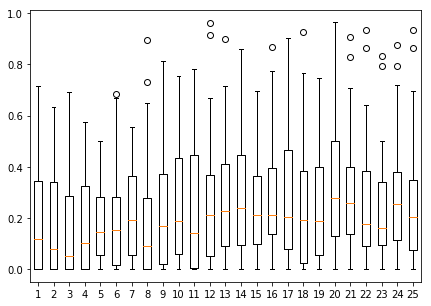

In [164]:
plt.figure(figsize=(7,5))

print(len(metrics[0]))

plt.boxplot(metrics)

plt.show()